In [1]:
import numpy as np
import tensorflow as tf
import operator

#Las siguientes 2 lineas son para ocupar la GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

from tensorflow.keras.models import Model, load_model
import chess
import chess.pgn

In [2]:
def codificar(board):
    WHITE=True
    b=str(board).replace(' ','').split('\n')
    a=np.zeros([8,8,5],dtype=np.uint8)
    mapeo={
        '.':[0,0,0,0,0],
        'r':[0,1,0,0,1],
        'n':[0,1,0,1,0],
        'b':[0,1,0,1,1],
        'q':[0,1,1,0,0],
        'k':[0,1,1,0,1],
        'p':[0,1,1,1,0],
        'R':[1,0,0,0,1],
        'N':[1,0,0,1,0],
        'B':[1,0,0,1,1],
        'Q':[1,0,1,0,0],
        'K':[1,0,1,0,1],
        'P':[1,0,1,1,0],
    }
    for i,row in enumerate(b):
        for j,val in enumerate(row):
            if val=='.':
                continue
            a[i,j,:]=mapeo[val]
    return a

In [3]:
#funcion para ordenar un diccionario por su valor de mayor a menor
def order(x):
    return  {k: v for k, v in sorted(x.items(), key=lambda item: item[1], reverse=True)}

In [4]:
def weights(x):
    l=len(x)
    a=(np.arange(l)+1)/l
    return tuple(zip(list(x.keys()),a))
    

In [5]:
class DeepBot:
    def __init__(self,path_model):
        self.eva = load_model(path_model)
        self.eva.summary()
    
    def select_move(self,board):
        moves=list(board.legal_moves)
        
        if len(moves)>1:
            code_moves=np.zeros([len(moves)*(len(moves)-1),2,8,8,5])
            value=[['xxxxx']*2]*(len(moves)*(len(moves)-1))
            rank={}
            i=0
            for m in moves:
                value[i]=0
                board.push(m)
                b1=codificar(board)
                board.pop()
                for n in moves:
                    if m!=n:
                        board.push(n)
                        b2=codificar(board)
                        board.pop()
                        b=np.array([b1,b2])
                        b=b.reshape([2,8,8,5])
                        code_moves[i,:]=b
                        value[i]=[m,n]
                        i+=1

            predict=self.eva.predict(code_moves)
            if board.turn: #turno de las blancas
                for i,pair in enumerate(value):
                    if predict[i]>0.5: #para las blancas >0.5 significa que el tablero de la izquierda es mejor
                        if pair[0] in rank:
                            rank[pair[0]]+=1
                        else:
                            rank[pair[0]]=1
                    else:
                        if pair[1] in rank:
                            rank[pair[1]]+=1
                        else:
                            rank[pair[1]]=1
            else:
                for i,pair in enumerate(value):
                    if predict[i]>0.5:
                        if pair[1] in rank:
                            rank[pair[1]]+=1
                        else:
                            rank[pair[1]]=1
                    else:
                        if pair[0] in rank:
                            rank[pair[0]]+=1
                        else:
                            rank[pair[0]]=1
            w=weights(order(rank))
        else:
            a=(moves[0],1)
            w=[a]

        return w
        

In [6]:
class RandomBot:
    def select_move(self,board):
        moves=list(board.legal_moves)
        return moves[np.random.randint(len(moves))]

In [7]:
path_model="white_nn.h5"
board = chess.Board()
blancas = DeepBot(path_model)
negras = RandomBot(board)

game = chess.pgn.Game()
game.headers["White"] = "DeepBot"
game.headers["Black"] = "RandomBot"
game.setup(board)  # Not required for the standard
                   # starting position.

node = game


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 2, 4, 4, 256)      32256     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 2, 64)       147520    
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 311,361
Trainable params: 311,361
Non-trainable params: 0
_________________________________________________________________


In [8]:
blancas.select_move(board)

((Move.from_uci('c2c4'), 0.05),
 (Move.from_uci('d2d4'), 0.1),
 (Move.from_uci('e2e4'), 0.15),
 (Move.from_uci('d2d3'), 0.2),
 (Move.from_uci('g2g3'), 0.25),
 (Move.from_uci('b1c3'), 0.3),
 (Move.from_uci('b1a3'), 0.35),
 (Move.from_uci('a2a4'), 0.4),
 (Move.from_uci('g1h3'), 0.45),
 (Move.from_uci('f2f3'), 0.5),
 (Move.from_uci('g1f3'), 0.55),
 (Move.from_uci('a2a3'), 0.6),
 (Move.from_uci('b2b4'), 0.65),
 (Move.from_uci('e2e3'), 0.7),
 (Move.from_uci('c2c3'), 0.75),
 (Move.from_uci('h2h3'), 0.8),
 (Move.from_uci('b2b3'), 0.85),
 (Move.from_uci('f2f4'), 0.9),
 (Move.from_uci('g2g4'), 0.95),
 (Move.from_uci('h2h4'), 1.0))

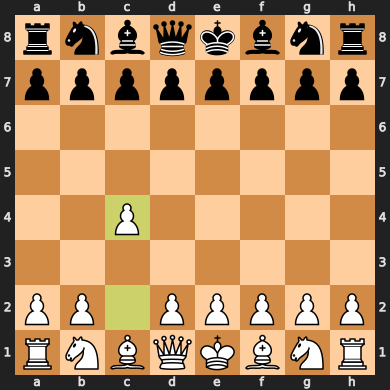

In [9]:
board.push(blancas.select_move(board)[0][0])
board

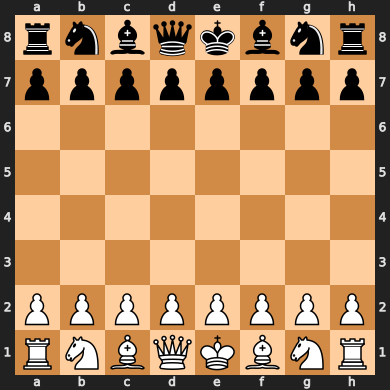

In [10]:
board.pop()
board

In [11]:
len(list(board.legal_moves))

20

In [12]:
while not board.is_game_over():
    move=blancas.select_move(board)[0][0]
    board.push(move)
    node = node.add_variation(move) # Add game node
    if not board.is_game_over():
        move=negras.select_move(board)
        board.push(move)
        node = node.add_variation(move) # Add game node
game.headers["Result"] = board.result()        
board.result()


'1/2-1/2'

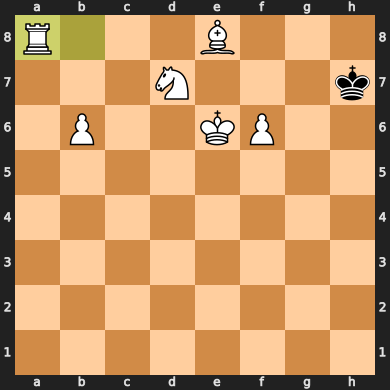

In [13]:
board
    

In [14]:
print(game)

[Event "?"]
[Site "?"]
[Date "????.??.??"]
[Round "?"]
[White "DeepBot"]
[Black "RandomBot"]
[Result "1/2-1/2"]

1. c4 Nf6 2. Nc3 d5 3. cxd5 g6 4. a4 Bg4 5. Nf3 Bf5 6. g4 Nh5 7. e3 Qd7 8. Bc4 Qxa4 9. Qxa4+ Nd7 10. Qxd7+ Kxd7 11. Rxa7 b6 12. Rxa8 Bxg4 13. h3 Nf4 14. exf4 Bf5 15. Rc8 h6 16. Na4 e6 17. Nxb6+ Ke7 18. Rxc7+ Kd8 19. d6 Bxd6 20. Kd1 Rh7 21. Re1 Be4 22. Rd7+ Ke8 23. Ne5 Rg7 24. h4 Bxe5 25. Bb3 Bd4 26. Rxd4 f6 27. d3 e5 28. Be3 Bb7 29. fxe5 Re7 30. exf6 Bf3+ 31. Kc1 Rg7 32. Rd1 Rc7+ 33. Kd2 Rd7 34. Nxd7 Bd5 35. Nc5 Bg8 36. Ke1 Bd5 37. Bf4 Bf7 38. Bd6 g5 39. hxg5 Kd8 40. gxh6 Bd5 41. Rxd5 Ke8 42. Be7 Kf7 43. Bc4 Kg6 44. Rf5 Kxf5 45. Ke2 Kg5 46. Bb5 Kf5 47. Be8 Ke5 48. d4+ Kd5 49. Ke3 Kc4 50. b3+ Kd5 51. b4 Kc4 52. Rb1 Kc3 53. Ke2 Kc2 54. b5 Kxb1 55. Kd3 Kb2 56. b6 Ka2 57. d5 Ka1 58. Nd7 Kb2 59. Kd4 Ka2 60. f3 Kb3 61. Bd6 Ka2 62. Be7 Ka1 63. Bd6 Kb2 64. Be7 Kc1 65. Bd6 Kd1 66. Bg3 Ke2 67. Ke4 Kd2 68. d6 Kc2 69. Ne5 Kd2 70. Bf2 Kc1 71. Bg3 Kd2 72. Bf2 Kd1 73. f4 Kc2 74. Bc6 Kc1 75